Instalação das bibliotecas `category-encoders` e `catboost`

In [1]:
!pip install category-encoders catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.6 MB/s eta 0:00:00


Importanto bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
import warnings

# Ignorar todos os warnings:

warnings.filterwarnings("ignore")

In [4]:
RANDOM_SEED = 42

# 1. Sobre o desenvolvimento do modelo de previsão de preços dos carros

Para o desenvolvimento do modelo de predição dos valores de carros, é importante notar que trabalha-se com diferentes variáveis e essas variáveis, dependendo do problema, vão se comportar como variáveis independentes (também denominadas como explicativas) ou como variável dependente (resposta ou alvo).

Portanto, o modelo a ser desenvolvido tenta predizer valores a partir de outras variáveis. O que configura o uso de **modelos supervisionados**, ou seja, espera-se que o modelo **retorne um valor resposta** de forma que a diferença entre os valores preditos e os valores reais seja minimizada. Os dois principais problemas de modelos de *machine learning* supervisionados são:

> * **Classificação:** o objetivo é tentar prever a **categoria a qual a observação pertence.** Ou seja, as variáveis explicativas são usadas para prever a que grupo aquela observação faz parte. Alguns exemplos são: detecção de fraudes, detecção de doenças, problemas envolvendo *churn*, detecção de *spam*.
>
> * **Regressão:** nesse caso o objetivo é prever um **valor numérico contínuo** tendo como base as variáveis de entrada. São exemplos mais comuns desse tipo de modelo: previsão de preços de casas, preços de carros, previsão de demanda, lucros ou custos.

Portanto, o modelo que será desenvolvido nesse *notebook*, dado que deseja-se prever preços de automóveis, ou seja, **valores numéricos contínuos**, será um modelo supervisionado de regressão.

# 2. Carregando dados de treino

In [5]:
# Instancia-se o dataframe com os dados de treino:

train_data = pd.read_csv(
    '/content/drive/MyDrive/Lighthouse/cars_train.csv',
    sep= '\t', encoding= 'utf-16'
)

# Visualização de parte do dataframe:

train_data.head(2)

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,...,elegivel_revisao,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,veiculo_alienado,preco
0,300716223898539419613863097469899222392,8.0,NISSAN,KICKS,1.6 16V FLEXSTART SL 4P XTRONIC,2017,2017.0,67772.0,CVT,4,...,False,NaN,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,NaN,NaN,74732.590084
1,279639842134129588306469566150288644214,8.0,JEEP,COMPASS,2.0 16V FLEX LIMITED AUTOMÁTICO,2017,2017.0,62979.0,Automática,4,...,False,Aceita troca,NaN,NaN,IPVA pago,NaN,NaN,NaN,NaN,81965.332634


## 2. Dicionário do *dataset*

> * **id:** Contém o identificador único dos veículos cadastrados na base de dados
>
> * **num_fotos:** contém a quantidade de fotos que o anuncio do veículo contém
>
> * **marca:** Contém a marca do veículo anunciado
>
> * **modelo:** Contém o modelo do veículo anunciado
>
> * **versao:** Contém as descrições da versão do veículo anunciando. Sua cilindrada, quantidade de válvulas, se é flex ou não, etc.
>
> * **ano_de_fabricacao:** Contém o ano de fabricação do veículo anunciado
>
> * **ano_modelo:** Contém o modelo do ano de fabricação do veículo anunciado
>
> * **hodometro:** Contém o valor registrado no hodômetro do veículo anunciado
>
> * **cambio:** Contém o tipo de câmbio do veículo anunciado
>
> * **num_portas:** Contém a quantidade de portas do veículo anunciado
tipo: Contém o tipo do veículo anunciado. Se ele é sedã, hatch, esportivo, etc.
>
> * **blindado:** Contém informação se o veículo anunciado é blindado ou não
>
> * **cor:** Contém a cor do veículo anunciado
>
> * **tipo_vendedor:** Contém informações sobre o tipo do vendedor do veículo anunciado. Se é pessoa física (PF) ou se é pessoa jurídica (PJ)
>
> * **cidade_vendedor:** Contém a cidade em que vendedor do veículo anunciado reside
>
> * **estado_vendedor:** Contém o estado em que vendedor do veículo anunciado reside
>
> * **anunciante:** Contém o tipo de anunciante do vendedor do veículo anunciado. Se ele é pessoa física, loja, concessionário, etc
entrega_delivery: Contém informações se o vendedor faz ou não delivery do veículo anunciado
>
> * **troca:** Contém informações o veículo anunciado já foi trocado anteriormente
elegivel_revisao: Contém informações se o veículo anunciado precisa ou não de revisão
>
> * **dono_aceita_troca:** Contém informações se o vendedor aceita ou não realizar uma troca com o veículo anunciado
>
> * **veiculo_único_dono:** Contém informações o veículo anunciado é de um único dono
>
> * **revisoes_concessionaria:** Contém informações se o veículo anunciado teve suas revisões feitas em concessionárias
>
> * **ipva_pago:** Contém informações se o veículo anunciado está com o IPVA pago ou não
>
> * **veiculo_licenciado:** Contém informações se o veículo anunciado está com o licenciamento pago ou não
>
> * **garantia_de_fábrica:** Contém informações o veículo anunciado possui garantia de fábrica ou não
>
>* **revisoes_dentro_agenda:** Contém informações se as revisões feitas do veículo anunciado foram realizadas dentro da agenda prevista
>
> * **veiculo_alienado:** Contém informações se o veículo anunciado está alienado ou não
>
> * **preco (target)**: Contém as informações do preço do veículo anunciado


## 3.1. Dimensões do *dataframe*

In [6]:
train_data.shape

(29584, 29)

> 29584 linhas e 29 colunas.

## 3.2. Infos do *dataframe*

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       29584 non-null  object 
 1   num_fotos                29407 non-null  float64
 2   marca                    29584 non-null  object 
 3   modelo                   29584 non-null  object 
 4   versao                   29584 non-null  object 
 5   ano_de_fabricacao        29584 non-null  int64  
 6   ano_modelo               29584 non-null  float64
 7   hodometro                29584 non-null  float64
 8   cambio                   29584 non-null  object 
 9   num_portas               29584 non-null  int64  
 10  tipo                     29584 non-null  object 
 11  blindado                 29584 non-null  object 
 12  cor                      29584 non-null  object 
 13  tipo_vendedor            29584 non-null  object 
 14  cidade_vendedor       

## 3.3. Dados faltantes

A análise exploratória dos dados, realizada em outro *notebook*, já havia mostrado que algumas colunas do conjunto de dados possuem grande quantidade de dados faltantes. Para visualizar, novamente, essas colunas e a proporção de dados faltantes:

In [8]:
valores_faltantes_por_coluna = train_data.isna().sum()
numero_total_de_observacoes = train_data.shape[0]

In [9]:
dados_faltantes = pd.DataFrame({
    'Dados faltantes (absolutos)': train_data.isna().sum(),
    'Dados faltantes (%)': round((valores_faltantes_por_coluna/numero_total_de_observacoes) * 100, 2)
})

dados_faltantes

,Dados faltantes (absolutos),Dados faltantes (%)
id,0,0.00
num_fotos,177,0.60
marca,0,0.00
modelo,0,0.00
versao,0,0.00
ano_de_fabricacao,0,0.00
ano_modelo,0,0.00
hodometro,0,0.00
cambio,0,0.00
num_portas,0,0.00


As colunas com mais de 20% de dados faltantes serão removidas. São elas: `dono_aceita_troca`, `veiculo_único_dono`, `revisoes_concessionaria`, `ipva_pago`, `veiculo_licenciado`, `garantia_de_fábrica`, `revisoes_dentro_agenda`, `veiculo_alienado`.

> * Tal escolhe se deve ao fato de que imputar dados nessas colunas pode introduzir um viés aos dados.
>
> * Ademais, as colunas `ipva_pago` e `dono_aceita_troca` contém dados em que se espera valores afirmativos ou negativos (sim ou não, False ou True), porém só há o valor afirmativo, mas não o negativo. O que leva a suposição de que os valores faltantes, na verdade, deveriam ser uma afirmação negativa. Porém, como não sabe-se a fonte dos dados, admitir isso e imputar valores negativos nessas colunas, talvez fosse introduzir um viés.

In [10]:
# Colunas que serão eliminadas:

colunas_para_drop = [
    'dono_aceita_troca', 'veiculo_único_dono', 'revisoes_concessionaria',
    'ipva_pago', 'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda',
    'veiculo_alienado'
]

In [11]:
# Dataframe com as colunas especificadas removidas:

train_data = train_data.drop(colunas_para_drop, axis= 1)

In [12]:
train_data.head(1)

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,...,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,preco
0,300716223898539419613863097469899222392,8.0,NISSAN,KICKS,1.6 16V FLEXSTART SL 4P XTRONIC,2017,2017.0,67772.0,CVT,4,...,N,Branco,PF,Rio de Janeiro,São Paulo (SP),Pessoa Física,False,False,False,74732.590084


## 3.4. Dados duplicados

In [13]:
train_data.loc[train_data.duplicated()]

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,...,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,preco


> Sem presença de dados duplicados.

# 4. Tratamento dos dados

## 4.1. Remoção da coluna `elegivel_revisao`

In [14]:
train_data['elegivel_revisao'].unique()

array([False])

> A coluna `elegivel_revisao` contém apenas um único valor (`False`). Portanto, por ser uma constante, é irrelevante para o modelo.

In [15]:
# Dataframe com a coluna elegivel_revisao removida:

train_data = train_data.drop('elegivel_revisao', axis= 1)

## 4.3. Transformação dos dados *booleanos*

As colunas `entrega_delivery` e `troca` possuem dados do tipo `bool`. Os valores podem ser mapeados de forma que `False` corresponderá a 0 e `True` a 1.

In [16]:
# Os valores são mapeados e substituidos:

train_data['entrega_delivery'] = train_data['entrega_delivery'].map({False: 0, True: 1})
train_data['troca'] = train_data['troca'].map({False: 0, True: 1})

## 4.2. Remoção de dados inconsistentes

Na análise exploratória foi possível detectar algumas inconsistências nos dados:

> * Veículos com **mais de um ano** de diferença entre ano do modelo e ano de fabricação do veículo. Normalmente na indústria automobilística um carro é produzido pelo menos alguns meses antes do ano de seu modelo. Existem carros **com mais de 20 anos de diferença** entre essas variáveis no conjunto de dados. Portanto, é bem provável que sejam valores equivocados, e esses dados serão removidos.
>
> * Há alguns veículos no conjunto de dados, bem poucos, que possuem 3 portas. O que é um valor bem exótico e bem raro em qualquer automóvel. Por isso também podem ser inconsistências que serão removidas.

In [17]:
# Coluna com diferença entre ano do modelo e ano de fabricação:

train_data['diferenca_modelo_fabricacao'] = train_data['ano_modelo'] - train_data['ano_de_fabricacao']

# Seleção dos dados em que a diferença é de 1 ano ou menos e com nº de portas diferente de 3:

train_data = train_data.query('diferenca_modelo_fabricacao <= 1 and num_portas != 3')

# Remoção da coluna diferenca_modelo_fabricacao:

train_data = train_data.drop('diferenca_modelo_fabricacao', axis= 1)

In [18]:
train_data.shape

(26283, 20)

> Dimensões do conjunto de dados após remoção das inconsistências.

# 5. Análise de correlação

Essa análise pode ser feita utilizando um **heatmap**, mapa de calor em português.

A análise de correlação indica se as variáveis possuem correlação linear entre si. Além disso, correlações fortes entre variáveis explicativas podem ser um indicativo de **multicolinearidade.**

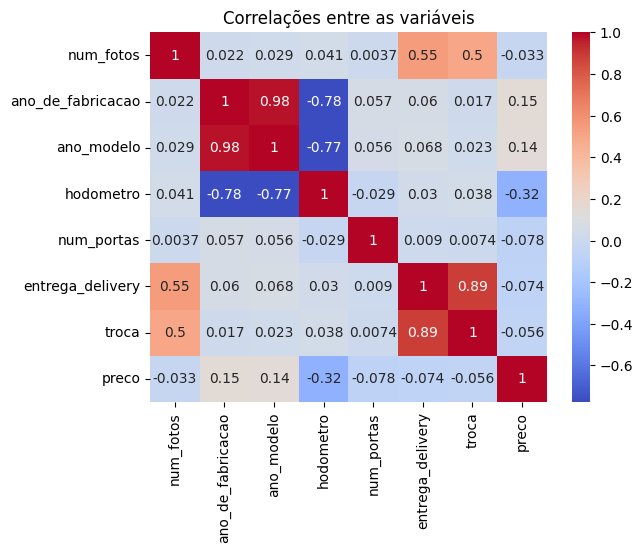

In [19]:
ax = sns.heatmap(data= train_data.corr(), annot= True, cmap= 'coolwarm')
ax.set_title('Correlações entre as variáveis')
plt.show()

> Analisando o **mapa de calor** uma correlação quase perfeita entre `ano_modelo` e `ano_de_fabricacao`. Uma correlação moderada entre essas variáveis e `hodometro`, mas também uma correlação forte entre `entrega_delivery` e `troca`.

No geral, **multicolinearidade** não interfere na previsão dos dados, mas atrapalha caso se deseje realizar alguma inferência estatística, como interpretar os coeficientes do modelo de **regressão linear.** Caso se deseje determinar a **multicolinearidade** é possível usar o $VIF$. Normalmente se considera que há **multicolinearidade** quando $VIF > 5$.

In [20]:
vif = pd.DataFrame()
alta_correlacao = train_data[['hodometro', 'ano_modelo', 'ano_de_fabricacao', 'entrega_delivery', 'troca']]
vif['features'] = alta_correlacao.columns
vif['VIF'] = vif["VIF"] = [variance_inflation_factor(alta_correlacao.values, i) for i in range(len(alta_correlacao.columns))]
vif

,features,VIF
0,hodometro,4.390898e+00
1,ano_modelo,1.644920e+07
2,ano_de_fabricacao,1.644953e+07
3,entrega_delivery,5.832822e+00
4,troca,5.590944e+00


> Há **multicolinearidade** entre as variáveis `ano_modelo` e `ano_de_fabricacao`, além das variáveis `troca` e `entrega_delivery`.

In [21]:
# As colunas ano_de_fabricacao e entrega_delivery são retiradas do dataframe:

train_data = train_data.drop(['ano_de_fabricacao', 'entrega_delivery'], axis= 1)

# 6. Modelagem para o problema de regressão

## 6.1. Variáveis independentes e dependente (alvo)

Opta-se pela remoção da variável `num_fotos` das *features* dado que a quantidade de fotos é mais uma questão de divulgação do anúncio do que de definição do preço do automóvel. Além disso, removendo essa coluna reduzimos o *pipeline*, visto que ela tem uma quantidade pequena de dados faltantes, mas que deveriam ser tratados.

In [22]:
# Variáveis independentes:

X_train = train_data.drop(['preco', 'id', 'num_fotos'], axis= 1) # id também é removida, visto que são valores que identificam os veículos.

# Variável dependente:

y_train = train_data['preco']

In [23]:
# Instancia-se o KFold:

kfold = KFold(n_splits= 5, shuffle= True, random_state= RANDOM_SEED)

> O *KFold* será usado posteriormente na validação cruzada.

## 6.2. Montagem do *pipeline*

In [24]:
# Colunas com dados categóricos:

colunas_categoricas = X_train.select_dtypes('object').columns

# Colunas com dados numéricos:

colunas_numericas = X_train.select_dtypes('number').columns

O pré-processamento dos dados se dará com o *encoding* das variáveis categóricas e a normalização dos dados.

> * `CatBoostEncoder`: variáveis categóricas em formato de texto não costumam ser interpretadas por diversos modelos. Portanto, é necessário que essa informação seja transformada para algum tipo de valor numérico. O `CatBoostEncoder` determina, com diferentes estatísticas, uma relação com a variável alvo. **O uso desse *encoder* se deve ao fato de evitar o aumento na cardinalidade dos dados, o que ocorreria com o `OneHotEncoder`, visto que existem muitas classes no conjunto de dados.**
>
> * `MinMaxScaler`: dados numéricos podem estar presentes em diferentes unidades e diferentes escalas. O problema é que **escalas maiores tendem a fazer com que o modelo dê maior peso a tais variáveis.** Portanto, o uso de algum tipo de *scaler* busca evitar essa distorção. Outra opção é padronizar os dados com `StandardScaler`, no entanto, **os dados do conjunto de dados não seguem uma distribuição normal, sendo mais indicado a sua normalização.** Ela é feita da seguinte forma:

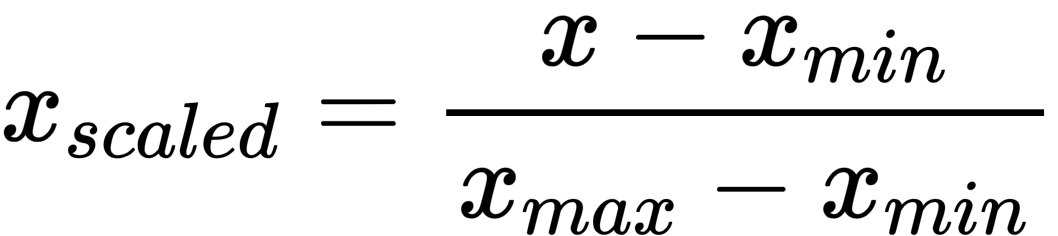

In [25]:
# Pré-processamento dos dados, o objeto preprocessing fará parte do pipeline:

preprocessing = ColumnTransformer(
    transformers= [
        ('categorical', CatBoostEncoder(), colunas_categoricas),
        ('numerical', MinMaxScaler(), colunas_numericas)
    ],
)

In [26]:
# Modelos que serão testados com validação cruzada:

models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'CatBoostRegressor': CatBoostRegressor(verbose= False),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': LGBMRegressor()

}

O interesse é usar diferentes modelos, a partir de uma métrica determinada, para testar aquele que desempenha melhor com os dados fornecidos. Entre os modelos instanciados há aqueles:

> * **Regressão linear:** como os modelos de `LinearRegression`, `Lasso`, `Ridge` e `ElasticNet`. Nesses modelos uma reta que passa pelos pontos é ajustada de forma que o erro seja o menor possível. Os modelos `Lasso`, `Ridge` e `ElasticNet`apresentam algum tipo de regularização de forma a penalizar coeficientes muito grandes, muito pequenos ou ambos.
>
> * **Árvore de decisão:** é o caso do modelo `DecisionTreeRegressor`. Nesses modelos o conjunto de dados é dividido em partes menores, para cada etapa o melhor atributo para dividir os dados é selecionado. Ao percorrer a árvore para uma nova amostra, chega a uma folha e prevê o valor médio dos alvos das amostras associadas a essa folha.
>
> * **Esemble:** algoritmos do tipo **esemble** são aqueles que combinam múltiplos modelos, podendo ser do mesmo tipo ou de tipos diferentes, os modelos `RandomForest, `GradientBoostingRegressor`, `CatBoosRegressor`, `XGBRegressor` e ``LGBMRegressor` estão nessa categoria. Os algoritmos desse tipo, no geral, são mais poderosos do que modelos simples. Porém, é importante testar diferentes modelos, pois essa afirmação nem sempre é verdadeira.

A métrica escolhida para o **raiz do erro quadrático médio negativo (RMSE negativo)**. Tanto essa métrica quanto o **erro absoluto médio negativo (MAE negativo)**, retornam uma métrica na unidade da variável resposta, ou seja, em reais. No entanto, o **RMSE** penaliza eventuais erros mais significativos. O **RMSE** é calculado da seguinte forma:

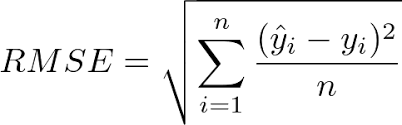



> O **raiz do erro quadrático médio negativo** é obtido pela multiplicação do **RMSE** por **-1.** Vale ressaltar que quanto mais próximo de **zero**, melhor.

In [27]:
for model_name, model_config in models.items():
  pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', model_config)
])

  result = cross_val_score(pipeline, X_train, y_train, cv= kfold, scoring= 'neg_root_mean_squared_error')
  print(f'{model_name} score: {result.mean()}')

LinearRegression score: -45568.13256342504
Lasso score: -45567.796920509674
Ridge score: -45566.9905968006
ElasticNet score: -47181.6872797647
DecisionTreeRegressor score: -63330.32850868414
RandomForestRegressor score: -42996.76734436992
GradientBoostingRegressor score: -43269.41305825578
CatBoostRegressor score: -42055.37622462952
XGBRegressor score: -43666.26442068225
LGBMRegressor score: -42313.184209135274


> Com base nessa métrica, o algoritmo `CatBoostRegressor` é o que melhor performa com o conjunto de dados.

## 6.3. Otimização de hiperparâmetros

O modelo `CatBoostRegressor` funciona com *gradient boosting*, que é um processo em que, iterativamente, diferentes árvores de decisão são construídas. **Cada árvore posterior melhora a performance da árvore anterior.** Portanto, é um algorítmo baseado em árvore de decisão.

> * **Vantagens:** lida com variáveis categóricas automaticamente e com dados ausentes, boa precisão na previsão dos dados e implementa mecanismos para evitar *overfitting*.
>
> * **Desvantagens:** possui muitos hiperparâmetros, o que por si não é ruim, mas pode ser mais demorado configurá-los, maior uso de memória que outros algorítmos de *boosting*.

In [28]:
# Definindo o pipeline para o CatBoostRegressor utilizando o mesmo pré-processamento:

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('regressor', CatBoostRegressor(verbose= False, loss_function= 'RMSE', random_state= RANDOM_SEED))
])

> O parâmetro **loss_function** determina qual a função de perda o modelo utilizará, ou seja, como o algorítmo será "guiado" para a sua otimização. No caso, é feita a escolha pela **raiz do erro quadrático médio (RMSE).**

In [29]:
# Parâmetros que serão passados ao otimizador:

param_grid = {
    'regressor__depth': [x for x in range(1, 7)],
    'regressor__learning_rate': [0.01, 0.01, 0.01, 1.0],
    'regressor__l2_leaf_reg': [1, 3, 5],
    'regressor__iterations': [100, 200, 300, 500, 1000]
}

O `RandomizedSearchCV` realiza **buscas aleatórias** no conjunto de hiperparâmetros definido. Como o conjunto testado é relativamente grande, uma busca com `GridSearchCV` ou `BayesSearchCV` talvez fosse mais exigente, o que tornaria a otimização mais lenta.  

In [30]:
# Execução da busca dos melhores hiperparâmetros:

random_search = RandomizedSearchCV(pipeline, param_grid, cv= kfold, scoring= 'neg_root_mean_squared_error', random_state= RANDOM_SEED)

In [31]:
# Ajuste do modelo com dados de treino:

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               CatBoostEncoder(),
                                                                               Index(['marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'anunciante'],
      dtype='object')),
                                                                              ('numerical',
                                                                               MinMaxScale...
                                                                               Index(['ano_modelo', 'hodometro', 'num_portas', 'troca'], dtype='object'))])),
                                             ('regressor',
                                              <catboost.core.CatBoostRegressor object at 0x791e57c65630>)]),
                   param_distributions={'regressor__depth': [1, 2, 3, 4, 5, 6],
                                        'regressor__iterations': [100, 200, 300,
                                                                  500, 1000],
                                        'regressor__l2_leaf_reg': [1, 3, 5],
                                        'regressor__learning_rate': [0.01, 0.01,
                                                                     0.01,
                                                                     1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [32]:
# Retorna os melhores parâmetros:

random_search.best_params_

{'regressor__learning_rate': 0.01,
 'regressor__l2_leaf_reg': 5,
 'regressor__iterations': 500,
 'regressor__depth': 5}

In [33]:
# Média dos scores obtidos na validação cruzada:

random_search.cv_results_['mean_test_score']

array([-43773.81865894, -47917.6200393 , -43271.40942846, -52308.54421165,
       -46149.85931696, -44253.60999806, -45011.80856589, -46149.85931696,
       -52998.31953459, -55208.13075978])

## 6.4. *Features importances*

In [34]:
# Para acessar o modelo ajustado:

best_model = random_search.best_estimator_

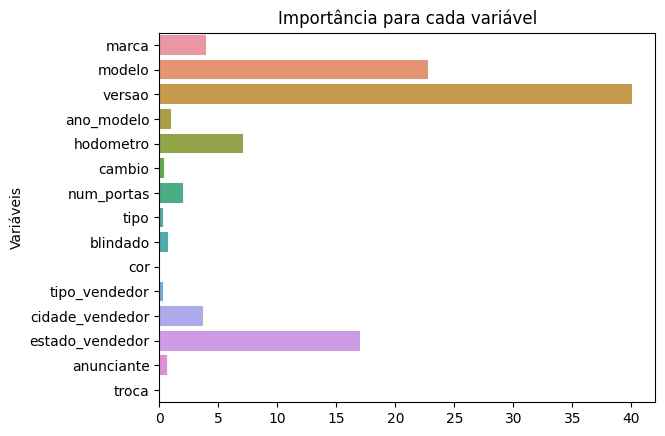

In [35]:
ax = sns.barplot(x= best_model.named_steps['regressor'].feature_importances_, y= X_train.columns)
ax.set_title('Importância para cada variável')
ax.set_ylabel('Variáveis')
plt.show()

## 6.5. Predição dos preços dos carros a partir dos dados de teste

In [36]:
# Os dados de teste são carregados:

test_data = pd.read_csv(
    '/content/drive/MyDrive/Lighthouse/cars_test.csv',
    sep= '\t', encoding= 'utf-16'
)

test_data.head()

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,...,troca,elegivel_revisao,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,veiculo_alienado
0,13518783164498355150900635905895481162,8.0,NISSAN,VERSA,1.6 16V FLEXSTART V-DRIVE MANUAL,2021,2021.0,20258.0,Manual,4,...,False,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,Garantia de fábrica,NaN,NaN
1,299896161723793383246777788797566040330,18.0,FIAT,STRADA,1.4 MPI WORKING CS 8V FLEX 2P MANUAL,2021,2021.0,53045.0,Manual,2,...,False,False,Aceita troca,Único dono,NaN,IPVA pago,Licenciado,NaN,NaN,NaN
2,316180649972302128246133616457018378621,8.0,AUDI,Q5,2.0 TFSI GASOLINA BLACK S TRONIC,2018,2019.0,32486.0,Automática,4,...,False,False,Aceita troca,NaN,NaN,IPVA pago,NaN,NaN,NaN,NaN
3,222527157104148385909188217274642813298,16.0,CHEVROLET,CRUZE,1.4 TURBO LT 16V FLEX 4P AUTOMÁTICO,2019,2020.0,24937.0,Automática,4,...,False,False,Aceita troca,Único dono,NaN,IPVA pago,Licenciado,NaN,NaN,NaN
4,160460343059850745858546502614838368036,8.0,FORD,ECOSPORT,1.5 TI-VCT FLEX SE AUTOMÁTICO,2019,2019.0,62074.0,Automática,4,...,False,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN


In [37]:
# Dimensão dos dados de teste:

test_data.shape

(9862, 28)

Os mesmos tratamentos realizados nos dados de treino devem ser feitos nos dados de teste:

In [38]:
# Criação de coluna com a diferença entre ano do modelo e ano de fabricação:

test_data['diferenca'] = test_data['ano_modelo'] - test_data['ano_de_fabricacao']

# Selecionam-se apenas os dados de veículos com 1 ano ou menos de diferença e com nº de portas diferente de 3:

test_data = test_data.query('diferenca <= 1 and num_portas != 3')

# A coluna criada é removida:

test_data = test_data.drop('diferenca', axis= 1)

test_data.shape # e as dimensões do dataframe mostradas.

(8711, 28)

A variável `id` é persistida, visto que farão parte dos dados que devem ser exportados após a previsão dos valores dos carros:

In [39]:
id = test_data['id']

In [40]:
# Todas as colunas que foram removidas nos dados de treino também são removidas dos dados de teste:

colunas_para_drop = [
    'dono_aceita_troca', 'veiculo_único_dono', 'revisoes_concessionaria',
    'ipva_pago', 'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda',
    'veiculo_alienado', 'elegivel_revisao', 'ano_de_fabricacao', 'entrega_delivery',
    'id', 'num_fotos'
]

X_test = test_data.drop(colunas_para_drop, axis= 1)

O modelo ajustado com os dados de treino é utilizado para prever dados a partir do `X_test`, lembrando que o arquivo com dados de teste não contém a variável alvo.

In [41]:
y_pred = random_search.predict(X_test)

In [42]:
# Um dataframe com os preços preditos é instanciado:

precos_preditos = pd.DataFrame({'id': id, 'predicted': y_pred})
precos_preditos.head(10)

,id,predicted
0,13518783164498355150900635905895481162,78813.545418
1,299896161723793383246777788797566040330,75187.940718
2,316180649972302128246133616457018378621,245036.260401
3,222527157104148385909188217274642813298,90582.862054
4,160460343059850745858546502614838368036,96272.989438
5,262727202368986244371977784343233436999,69504.554025
6,254093764205800086330999281077926851120,137123.669155
7,26118184613036116787803832945215674478,225906.542826
8,216524630140335566712794225427064313,225875.418686
9,185631381169816366226494379020452029389,311512.442812


In [43]:
precos_preditos.shape

(8711, 2)

# 7. Exportação dos dados

In [44]:
precos_preditos.to_csv('predicted.csv', sep=',', index= False, encoding= 'utf-8')